In [37]:
from env import DATABASE_URI
from sqlalchemy import create_engine, text, select
from sqlalchemy.orm import Session, scoped_session, sessionmaker
from data_models import Data, Run, Module
from datetime import datetime
import matplotlib.pyplot as plt

In [38]:
#Get data from database

engine = create_engine(DATABASE_URI)
Session = scoped_session(sessionmaker(bind=engine))
session = Session()

query = select(Data).where(Data.run_id == 3)
data = session.execute(query).scalars().all()

In [41]:
#convert to csv 
import csv
with open("/home/hayden/repos/module_pcb_thermal_mockup/module_pcb_thermal_mockup_v3.5/software/run_3_ETROC4.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["timestamp", "celcius"])
    
    # Write the data
    for row in data:
        if row.sensor == 'E4':
            writer.writerow([row.timestamp, row.celcius])

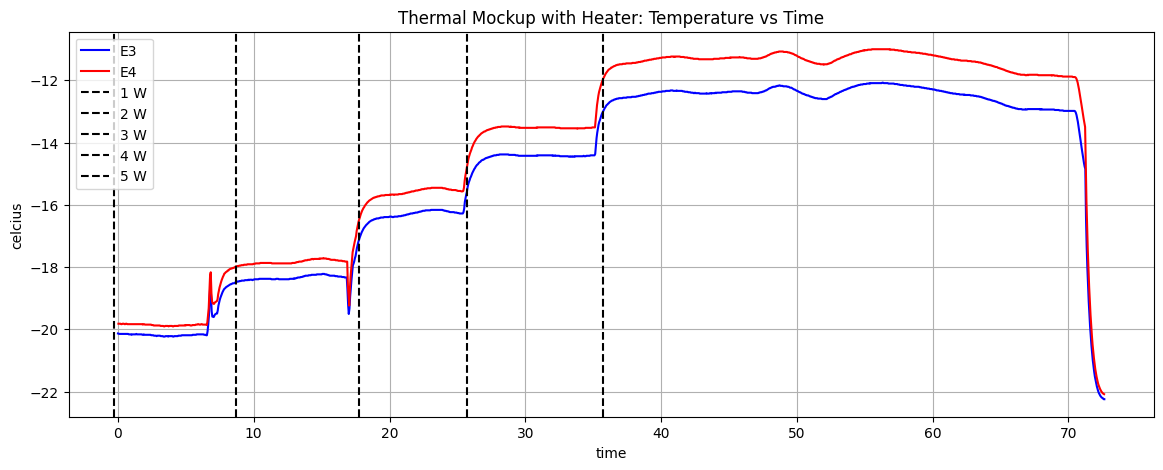

In [50]:
lbl_colors = {
    'E3': 'blue',
    'E4': 'red'
}

fig, ax = plt.subplots(figsize=(14,5))

t0 = data[0].timestamp
elapsed_time = lambda t: (t - t0).total_seconds() / 60 

e3_times = [elapsed_time(row.timestamp) for row in data if row.sensor == 'E3']
e3_temps = [row.celcius for row in data if row.sensor == 'E3']
e4_times = [elapsed_time(row.timestamp) for row in data if row.sensor == 'E4']
e4_temps = [row.celcius for row in data if row.sensor == 'E4']

# Plot the data for each sensor
if e3_times and e3_temps:
    ax.plot(e3_times, e3_temps, label='E3', color=lbl_colors['E3'])
if e4_times and e4_temps:
    ax.plot(e4_times, e4_temps, label='E4', color=lbl_colors['E4'])

ax.axvline(x = elapsed_time(datetime(2024,8,15,4,30)), color = 'black', label = '1 W', linestyle='--')
ax.axvline(x = elapsed_time(datetime(2024,8,15,4,39)), color = 'black', label = '2 W', linestyle='--')
ax.axvline(x = elapsed_time(datetime(2024,8,15,4,48)), color = 'black', label = '3 W', linestyle='--')
ax.axvline(x = elapsed_time(datetime(2024,8,15,4,56)), color = 'black', label = '4 W', linestyle='--')
ax.axvline(x = elapsed_time(datetime(2024,8,15,5,6)), color = 'black', label = '5 W', linestyle='--')

ax.set(
    xlabel='time',
    ylabel='celcius',
    title = 'Thermal Mockup with Heater: Temperature vs Time'
)

ax.legend()
ax.grid()
